In [1]:
import numpy as np
import matplotlib.pyplot as plt

dots = 10000
x_nodes = []
qs_coeff = np.zeros(shape=(1, 1))

In [2]:
def qubic_spline_coeff(x_nodes, y_nodes):
    n = len(x_nodes)
    
    h = [] #список значений h
    for i in range(0, n - 1):
        t = np.around(x_nodes[i + 1] - x_nodes[i], decimals = 6)
        h.append(t)
    
    ta = [1] #главная диагональ матрицы A 
    tb = []  #диагональ ниже главной
    tc = [0] #диагональ выше главной
    for i in range(0, n - 2):
        t1 = 2 * (h[i + 1] + h[i])
        t2 = h[i]
        t3 = h[i + 1]
        ta.append(t1)
        tb.append(t2)
        tc.append(t3)
    ta.append(1)
    tb.append(0)
    tta = np.diag(ta, 0)    #матрица с заполненной главной диагональю, остальное - 0
    ttb = np.diag(tb, -1)   #матрица с заполненной диагональю на одну ниже главной
    ttc = np.diag(tc, 1)    #матрица с заполненной диагональю на одну выше главной
    A = tta + ttb + ttc     #складываем все три матрциы и получаем матрицу A
    revA = np.linalg.inv(A) #находим обратную матрицу A\^\ (-1)
    
    F = np.zeros(shape = (n, 1)) #получим матрицу F
    for i in range(1, n - 1):
        t1 = y_nodes[i + 1] - y_nodes[i]
        t2 = y_nodes[i] - y_nodes[i - 1]
        F[i][0] = 3 * (t1 / h[i] - t2 / h[i - 1])
    
    c = np.dot(revA, F) #находим произведение матриц A\^\ (-1)*F как матрицу коэффициентов c
    
    a = np.zeros(shape = (n - 1, 1))
    b = np.zeros(shape = (n - 1, 1))
    d = np.zeros(shape = (n - 1, 1))
    for i in range(0, n - 1):
        a[i][0] = y_nodes[i]
        b[i][0] = (1 / h[i]) * (y_nodes[i + 1] - y_nodes[i]) - h[i] / 3 * (c[i + 1] + 2 * c[i])
        d[i][0] = (c[i + 1][0] - c[i][0]) / (3 * h[i])
    
    c = np.delete(c, obj = 10, axis = 0) #удаляем последний элемент матрицы, так как тот лишний

    coeffs = np.c_[a, b, c, d]
    
    return coeffs

In [3]:
def qubic_spline(x_nodes, x, qs_coeff):
    i = int(x * 500)
    if i == 1000:
        i -= 1
        
    a = qs_coeff[i][0]
    b = qs_coeff[i][1]
    c = qs_coeff[i][2]
    d = qs_coeff[i][3]
    difX = x - x_nodes[i]
    s_x = a + b * difX + c * difX ** 2 + d * difX ** 3
            
    return s_x

In [4]:
def y_function_approx(x):
    C = 1.03439984
    
    eps = 1
    t = 0
    while eps >= 0.000000000001:
        while C * (t - (1. / 2) * np.sin(2 * t)) <= x:
            t += eps
        t -= eps
        eps /= 10
        
    y = C * (1. / 2) * (1 - np.cos(2 * t))
    
    return y

In [5]:
def composite_simpson(a, b, n, f):
    n += (n + 1) % 2
    
    pr = n - 1
    h = (b - a) / pr
    x = a + h                  #x_2
    
    sum1 = 0
    sum2 = f(x)                #f(x_2)
    for i in range(1, pr // 2):
        x += 2 * h
        sum1 += f(x - h)       #f(x_3),f(x_5), ...
        sum2 += f(x)           #f(x_4),f(x_6), ...
        
    result = (h / 3) * (f(a) + 2 * sum1 + 4 * sum2 + f(b))
    
    return result

In [6]:
def composite_trapezoid(a, b, n, f):
    pr = n - 1
    
    h = (b - a) / pr
    x = a
    
    sum0 = 0
    for i in range(2, pr + 1):
        x += h
        sum0 += f(x)
        
    result = (h / 2) * (f(a) + 2 * sum0 + f(b))
    
    return result

In [7]:
def under_integral_function(x):
    global x_nodes, qs_coeff
    
    return 1 / qubic_spline(x_nodes, x, qs_coeff)

In [8]:
def error_for_function(a, b, n, func):
    global dots
    
    ta = 1 / dots 
    C = 1.03439984
    g = 9.81
    T = 1.75418438
    
    exact_integral = np.sqrt(2 * C / g) * (T - ta)
    qq = np.sqrt(C / (2 * g))
    
    er0 = np.abs(exact_integral - qq * func(a, b, n, under_integral_function))
    
    return er0

In [9]:
def nodes_creation(a, b):
    global x_nodes, qs_coeff
    
    x_nodes = []
    y_nodes = []
    
    h = (b - a) / 1000
    for i in range(0, 1001):
        x_nodes.append(np.around(a + i * h, decimals=3))
        y_nodes.append(y_function_approx(x_nodes[i]))
    
    qs_coeff = qubic_spline_coeff(x_nodes, y_nodes)

In [13]:
def plotParagraph3():
    global dots
    fig, ax = plt.subplots(figsize=(12, 8))
     
    n = np.linspace(3, 9999, 9997, dtype=int)
    a = 1 / dots
    b = 2
    nodes_creation(a, b)
    ax.loglog((b - a) / (n - 1), [error_for_function(a, b, n_, composite_simpson) for n_ in n], 'o', label='simpson', markersize = 2)
    ax.loglog((b - a) / (n - 1), [error_for_function(a, b, n_, composite_trapezoid) for n_ in n], 'o', label='trapezoid', markersize = 2)
    
    ax.grid(True)
    ax.set_xlabel(r'$h$', fontsize=16)
    ax.set_ylabel(r'$E$', fontsize=16)
    ax.legend(fontsize=16)
    
    plt.savefig('basicPlot2.pdf')

KeyboardInterrupt: 

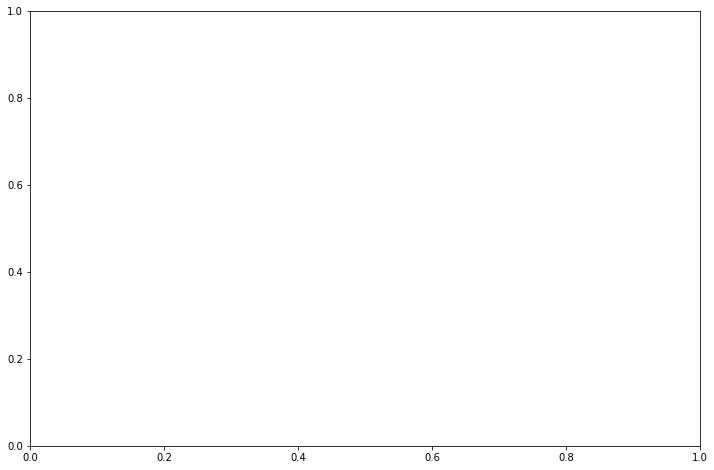

In [12]:
if __name__ == '__main__':
    plotParagraph3()